In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import oyster

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Electrode locations for patient TB, from MATLAB script
x_elec_loc = np.array([-6825.092215, -6332.563035, -5840.033855, -5347.504675,
                       -6194.683612, -5702.154432, -5209.625252, -4717.096072,
                       -5564.275010, -5071.745829, -4579.216649, -4086.687469,
                       -4933.866407, -4441.337226, -3948.808046, -3456.278866])
y_elec_loc = np.array([-655.666769, -25.258166, 605.150437, 1235.559040,
                       -1148.195949, -517.787346, 112.621257, 743.029860,
                       -1640.725129, -1010.316526, -379.907924, 250.500679,
                       -2133.254310, -1502.845707, -872.437104, -242.028501])

# MATLAB had the OD at (0,0), we have it at (15,2)
x_elec_loc += e2cm.deg2micron(15)
y_elec_loc += e2cm.deg2micron(2)

r_arr = np.array([260, 520, 260, 520]) / 2.0
r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
h_arr = np.ones(16)*100

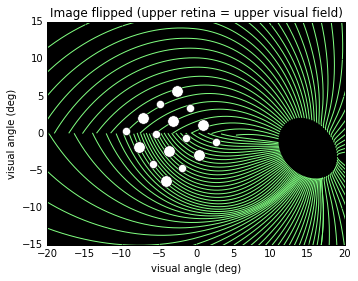

In [11]:
axon_x, axon_y = oyster.jansonius(100, 801)
axon_x = np.array(axon_x)
axon_y = np.array(axon_y)
fig, ax = plt.subplots(1)
ax.set_axis_bgcolor('black')
ax.plot(axon_x, -axon_y, c=(0.5, 1, 0.5))
for x, y, r in zip(x_elec_loc, y_elec_loc, r_arr):
    ax.plot(e2cm.micron2deg(x), -e2cm.micron2deg(y), 'ow', markersize=np.sqrt(r/2))
# ax.plot(e2cm.micron2deg(x_elec_loc), -e2cm.micron2deg(y_elec_loc), 'ow', markersize=10)
# ax.plot(e2cm.micron2deg(x_elec_loc[4]), e2cm.micron2deg(y_elec_loc[4]), 'ob', markersize=2)
ax.set_aspect('equal')
ax.set_xlim(-20, 20)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-15, 15)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')

In [4]:
# find x,y limits from electrode location
round_to_nearest = 200.0
x_min = np.floor((x_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
x_max = np.ceil((x_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest
y_min = np.floor((y_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
y_max = np.ceil((y_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest

r_sampling = 100  # spatial sampling of the retina
r_file = '../retina_argusI_s%d_%dx%d.npz' % (r_sampling, x_max - x_min, y_max - y_min)
r = e2cm.Retina(axon_map=r_file, sampling=r_sampling,
                xlo=x_min, xhi=x_max, ylo=y_min, yhi=y_max)

In [5]:
e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_elec_loc, y_elec_loc, h_arr.tolist())
ecs, cs  = r.electrode_ecs(e_all, integrationtype='dotproduct', normalizationtype='maxcs')

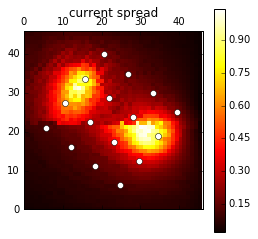

In [37]:
plt.matshow(ecs[..., [14, 2]].sum(axis=2), cmap='hot')

# also plot the center points of all the electrodes
plt.plot(x_elec_loc/r_sampling - x_min/r_sampling, y_elec_loc/r_sampling - y_min/r_sampling, 'ow')

plt.axis([0, (x_max - x_min) / r_sampling, 0, (y_max - y_min) / r_sampling])
# plt.axis([0, r.gridx.shape[0], 0, r.gridx.shape[1]])
plt.colorbar()
plt.title('current spread')

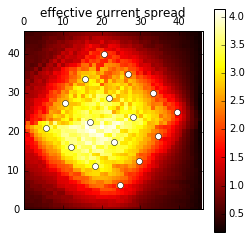

In [7]:
plt.matshow(ecs.sum(axis=2), cmap='hot')

# also plot the center points of all the electrodes
plt.plot(x_elec_loc/r_sampling - x_min/r_sampling, y_elec_loc/r_sampling - y_min/r_sampling, 'ow')

plt.axis([0, (x_max - x_min) / r_sampling, 0, (y_max - y_min) / r_sampling])
# plt.axis([0, r.gridx.shape[0], 0, r.gridx.shape[1]])
plt.colorbar()
plt.title('effective current spread')

In [8]:
np.max(cs, axis=(0,1))

array([ 0.85371929,  0.85371929,  0.85371929,  0.85371929,  0.85371929,
        0.85371929,  0.85371929,  0.85371929,  0.85371929,  0.85371929,
        0.85371929,  0.85371929,  0.85371929,  0.85371929,  0.85371929,
        0.85371929])

In [9]:
np.max(ecs, axis=(0,1))

array([ 1.08591498,  0.86769482,  0.97409683,  0.97223387,  1.09707616,
        0.85371929,  0.85371929,  1.14598323,  1.1933491 ,  1.29960344,
        0.97453315,  0.95541231,  1.12778883,  1.02476891,  0.99964945,
        1.1609677 ])